# Web Scraping, NLP and Random Forests for Reddit & Predicting Comments

Goal: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Data Collection Method: Reddits API python wrapper PRAW, and BeautifulSoup4

Feature Engineering: bag of words, and used a neat sentiment analyzer designed for social media texts called VaderSentimentAnalyzer

##### I Set up a request (using requests) to the r/all url. Used PRAW & BeautifulSoup to parse the page and extract the results

In [190]:
import requests
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import praw
import json
import time
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
#creates a authorized reddint instance, i had to https://www.reddit.com/prefs/apps and create a 'script app'
#this gave me the client id, and client secret. i already had a reddit account with a u/n and p/w
#using praw which is reddits api wrapper, i created a 'reddit' instance in with this code:
reddit = praw.Reddit(client_id='GmZJKxnSEWFAvg',
                     client_secret='P9Qz_XHGRXkY9wNbmlBrcv6Jc20',
                     password='********', 
                     user_agent='Ravi project 3',
                     username='rmproject3')

In [3]:
#checks to see if the oAuth worked
print(reddit.user.me())

rmproject3


In [4]:
URL = "https://www.reddit.com/r/all/"

In [5]:
reddit.read_only

False

In [6]:
df = pd.DataFrame(columns = ['title','subreddit','time','num_comments'])

for submission in reddit.subreddit('all').hot(limit = 5000):
    df.loc[len(df)] = submission.title, submission.subreddit.display_name, submission.created_utc, submission.num_comments
df


,title,subreddit,time,num_comments
0,"""I'll handle this, human.""",aww,1.519405e+09,303.0
1,Change My Mind,funny,1.519403e+09,5131.0
2,Step dad,yesyesyesyesno,1.519402e+09,267.0
3,The land of the ARs and Pistols,BlackPeopleTwitter,1.519403e+09,1612.0
4,MRW I don't understand the new subreddit theme...,HighQualityGifs,1.519405e+09,137.0
5,"Rick Gates, Trump Campaign Aide, to Plead Guil...",politics,1.519397e+09,2920.0
6,Immunity dog,wholesomememes,1.519399e+09,273.0
7,Bird photobombs meteorologist,gifs,1.519398e+09,696.0
8,"Let’s post the dumb, illegal things we do to s...",Whatcouldgowrong,1.519403e+09,776.0
9,Violent video games actually reduces violence ...,gaming,1.519397e+09,2495.0


In [7]:
#using bs4
headers = {'user_agent' : 'Ravi project 3'}
res = requests.get(URL, headers = headers)
soup = BeautifulSoup(res.text, 'lxml')
# threads = soup('a.title.may-blank')


So I wrote some functions to make life easier to scrape the soup object. If you right click 'inspect source' on any reddit page you'll see the html tags I used correspond to the metadata I wanted to scrape

In [11]:
## YOUR CODE HE
def get_titles():
    titles_list = []
    titles = soup.find_all('a', {'class':'title'}) #<a> class:title brings finds the titles of the page
    for title in titles:
        titles_list.append(title.text)
    
    return titles_list

get_titles()

['"I\'ll handle this, human."',
 'Change My Mind',
 'Step dad',
 'The land of the ARs and Pistols',
 "MRW I don't understand the new subreddit theme, but am fully on board",
 'Rick Gates, Trump Campaign Aide, to Plead Guilty in Mueller Inquiry and Cooperate',
 'Let’s post the dumb, illegal things we do to social media. WCGW?',
 'Immunity dog',
 'Bird photobombs meteorologist',
 "Japanese scientists invent floating 'firefly' light that could eventually be used in applications ranging from moving displays to projection mapping.",
 'Violent video games actually reduces violence amongst children',
 'P S Y C H I C',
 'Going for the Diplomatic Victory at the United Nations',
 'The original 1968 "Planet of the Apes" has the three apes on the Ruling Council "see no evil, hear no evil, and say no evil," thus reenacting the "Three Wise Monkeys" pose.',
 'What do you think that popular culture will romanticize about the 2010s?',
 'Incredible lenticular clouds over Alvord Desert in SE Oregon from 

In [12]:
def get_time():
    time_list = []
    time = soup.find_all('time', {'class':'live-timestamp'}) #html time is under these tags
    for t in time:
        time_list.append(t['title'])
    return time_list

get_time()

['Fri Feb 23 16:52:27 2018 UTC',
 'Fri Feb 23 16:17:59 2018 UTC',
 'Fri Feb 23 16:11:21 2018 UTC',
 'Fri Feb 23 16:25:40 2018 UTC',
 'Fri Feb 23 17:01:48 2018 UTC',
 'Fri Feb 23 14:37:48 2018 UTC',
 'Fri Feb 23 16:26:09 2018 UTC',
 'Fri Feb 23 15:14:30 2018 UTC',
 'Fri Feb 23 15:00:11 2018 UTC',
 'Fri Feb 23 17:33:56 2018 UTC',
 'Fri Feb 23 14:43:05 2018 UTC',
 'Fri Feb 23 16:00:58 2018 UTC',
 'Fri Feb 23 14:47:22 2018 UTC',
 'Fri Feb 23 14:57:48 2018 UTC',
 'Fri Feb 23 15:00:46 2018 UTC',
 'Fri Feb 23 14:16:11 2018 UTC',
 'Fri Feb 23 14:42:31 2018 UTC',
 'Fri Feb 23 14:48:56 2018 UTC',
 'Fri Feb 23 14:52:35 2018 UTC',
 'Fri Feb 23 13:57:24 2018 UTC',
 'Fri Feb 23 14:21:48 2018 UTC',
 'Fri Feb 23 12:41:42 2018 UTC',
 'Fri Feb 23 15:13:28 2018 UTC',
 'Fri Feb 23 13:35:16 2018 UTC',
 'Fri Feb 23 13:54:16 2018 UTC']

In [13]:
def get_subreddits():
    subreddits_list = []
    subreddits = soup.find_all('a', {'class':'subreddit hover may-blank'})  #html tags where subreddit of post is located
    for sub in subreddits:
        subreddits_list.append(sub.text)
    return subreddits_list

get_subreddits()

['r/aww',
 'r/funny',
 'r/yesyesyesyesno',
 'r/BlackPeopleTwitter',
 'r/HighQualityGifs',
 'r/politics',
 'r/Whatcouldgowrong',
 'r/wholesomememes',
 'r/gifs',
 'r/gadgets',
 'r/gaming',
 'r/dankmemes',
 'r/civ',
 'r/MovieDetails',
 'r/AskReddit',
 'r/EarthPorn',
 'r/food',
 'r/DunderMifflin',
 'r/UpliftingNews',
 'r/mildlyinteresting',
 'r/AnimalTextGifs',
 'r/pics',
 'r/iamverybadass',
 'r/ProgrammerHumor',
 'r/comics']

In [14]:
def get_numComments():
    comments_list = []
    comments = soup.find_all('a', {'data-event-action':'comments'}) #where to find number of comment on a post
    for c in comments:
        comments_list.append(c.text)
    return comments_list

get_numComments()

['333 comments',
 '5218 comments',
 '274 comments',
 '1650 comments',
 '139 comments',
 '2947 comments',
 '875 comments',
 '275 comments',
 '721 comments',
 '261 comments',
 '2516 comments',
 '148 comments',
 '343 comments',
 '256 comments',
 '7456 comments',
 '335 comments',
 '219 comments',
 '243 comments',
 '437 comments',
 '1931 comments',
 '125 comments',
 '1469 comments',
 '362 comments',
 '816 comments',
 '180 comments']

In [15]:
## YOUR CODE HERE


The url changes, looking at the 'next' button at the bottom of a reddit page you can see the url changes to something like:

```
https://www.reddit.com/r/all/?count=25&after=t3_787ptc
```

This URL  has two query parameters
- count, which equals the number of the results to start with, each page is 25 posts, so the second page would start at 25, the third count=50, 4th count=75 etc..
- after is the unique id of the last result on the _previous_ page

In order to scrape lots of pages from Reddit, we'll have to change these parameters every time we make a new request so that we're not just scraping the same page over and over again. 

In [17]:
## So here I am grabbing the id in the url that changes every time you click the 'next page' button 
def last_id():
    id_tags = soup.find_all('div', id=re.compile('thing_(.*)'))
    
    return re.findall('thing_(.*)', id_tags[-1]['id'])[0]
    
last_id()
# IN hind sight it would have been easier to just grab the url of the 'next button' and do a request on that. but i started


't3_7zo6e2'

## Putting it all together...

In [21]:
url_template = "http://www.reddit.com/r/all/?count={}&after={}"
max_results = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First I tested my code on a small number of results and then expanded.

results_df = pd.DataFrame(columns = ['title', 'time','subreddit','num_comments'])
last_post = ''

for start in range(0, max_results, 25):
    time.sleep(15)
    # Grab the results from the request (as above)
    # Append to the full set of results
    res = requests.get(url_template.format(start,last_post), headers = {'user_agent' : 'please'})
    soup = BeautifulSoup(res.text, 'lxml')
    
    print (soup.title)
    
    titles = get_titles()
    times = get_time()
    subreddits = get_subreddits()
    comments = get_numComments()
    last_post = last_id() 
    
    for t in range(len(titles)):
        results_df = results_df.append({'title': titles[t],
                                        'time' : times[t],
                                        'subreddit': subreddits[t],
                                        'num_comments' : comments[t]}, ignore_index = True)
    
    
    
    

<title>all subreddits</title>
<title>Too Many Requests</title>


IndexError: list index out of range

In [22]:
soup #debug check to see if reddit denied a request. 

<!DOCTYPE html>
<html>
<head>
<title>Too Many Requests</title>
<style>
      body {
          font: small verdana, arial, helvetica, sans-serif;
          width: 600px;
          margin: 0 auto;
      }

      h1 {
          height: 40px;
          background: transparent url(//www.redditstatic.com/reddit.com.header.png) no-repeat scroll top right;
      }
    </style>
</head>
<body>
<h1>whoa there, pardner!</h1>
<p>we're sorry, but you appear to be a bot and we've seen too many requests
from you lately. we enforce a hard speed limit on requests that appear to come
from bots to prevent abuse.</p>
<p>if you are not a bot but are spoofing one via your browser's user agent
string: please change your user agent string to avoid seeing this message
again.</p>
<p>please wait 3 second(s) and try again.</p>
<p>as a reminder to developers, we recommend that clients make no
    more than <a href="http://github.com/reddit/reddit/wiki/API">one
    request every two seconds</a> to avoid seeing this 

In [311]:
## compare to praw method above and we'll see its the same, just have to convert time to date time and we have 'r/'
# in subreddits, which i kinda like.
results_df.to_csv('bs4_csv.csv', encoding = 'utf-8', index = False)

,title,time,subreddit,num_comments
0,TIL when the Nazis burned Sigmund Freud's book...,Mon Feb 19 22:05:50 2018 UTC,r/todayilearned,1256 comments
1,The next Wayne Gretzky,Mon Feb 19 22:43:45 2018 UTC,r/gifs,648 comments
2,If I fits...,Mon Feb 19 22:18:03 2018 UTC,r/funny,321 comments
3,My girlfriend pressed her face in fresh snow,Mon Feb 19 22:25:12 2018 UTC,r/mildlyinteresting,613 comments
4,Mueller's interest in Kushner grows to include...,Mon Feb 19 21:03:20 2018 UTC,r/politics,955 comments
5,Joel McHale says E! told him to lay off the Ka...,Mon Feb 19 20:56:03 2018 UTC,r/television,866 comments
6,Wrong number,Mon Feb 19 20:27:31 2018 UTC,r/cringepics,831 comments
7,Roseanne Barr says Fergie's national anthem pe...,Mon Feb 19 20:32:54 2018 UTC,r/nottheonion,2416 comments
8,Hockey skills with a hug,Mon Feb 19 19:50:14 2018 UTC,r/MadeMeSmile,489 comments
9,Wigan 1-0 Manchester City - Will Grigg,Mon Feb 19 21:32:52 2018 UTC,r/soccer,626 comments


### Saving results as a CSV

In [32]:
# Export to csv
df.to_csv('praw_way.csv', encoding='utf-8', index=False)
#results_df.to_csv('bs4_way.csv', encoding = 'utf-8', index=False)

## Predicting comments using Random Forests + Naive Bayes

#### Load in the the data of scraped results

In [33]:
## using what i scraped with praw.
data = pd.read_csv('praw_way.csv')
data

,title,subreddit,time,num_comments
0,"""I'll handle this, human.""",aww,1.519405e+09,303.0
1,Change My Mind,funny,1.519403e+09,5131.0
2,Step dad,yesyesyesyesno,1.519402e+09,267.0
3,The land of the ARs and Pistols,BlackPeopleTwitter,1.519403e+09,1612.0
4,MRW I don't understand the new subreddit theme...,HighQualityGifs,1.519405e+09,137.0
5,"Rick Gates, Trump Campaign Aide, to Plead Guil...",politics,1.519397e+09,2920.0
6,Immunity dog,wholesomememes,1.519399e+09,273.0
7,Bird photobombs meteorologist,gifs,1.519398e+09,696.0
8,"Let’s post the dumb, illegal things we do to s...",Whatcouldgowrong,1.519403e+09,776.0
9,Violent video games actually reduces violence ...,gaming,1.519397e+09,2495.0


In [34]:
data['time'] = data['time'].map(lambda x: datetime.datetime.fromtimestamp(x))

In [85]:
data['hour'] = data['time'].map(lambda x: x.hour)

In [86]:
data.head()

,title,subreddit,time,num_comments,high_low,cat,funny,sentiment,hour
0,"""I'll handle this, human.""",aww,2018-02-23 11:52:27,303.0,1,0,0,0.0,11
1,Change My Mind,funny,2018-02-23 11:17:59,5131.0,1,0,0,0.0,11
2,Step dad,yesyesyesyesno,2018-02-23 11:11:21,267.0,1,0,0,0.0,11
3,The land of the ARs and Pistols,BlackPeopleTwitter,2018-02-23 11:25:40,1612.0,1,0,0,0.0,11
4,MRW I don't understand the new subreddit theme...,HighQualityGifs,2018-02-23 12:01:48,137.0,1,0,0,0.0,12


#### We want to predict a binary variable - whether the number of comments was low or high. I created a new binary variable that is true when the number of comments is high (above the median)

I could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, I converted this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.


In [35]:
#making a binary column
data['high_low'] = data['num_comments'].map(lambda x: 1 if x > data.num_comments.median() else 0)

In [36]:
data.head()

,title,subreddit,time,num_comments,high_low
0,"""I'll handle this, human.""",aww,2018-02-23 11:52:27,303.0,1
1,Change My Mind,funny,2018-02-23 11:17:59,5131.0,1
2,Step dad,yesyesyesyesno,2018-02-23 11:11:21,267.0,1
3,The land of the ARs and Pistols,BlackPeopleTwitter,2018-02-23 11:25:40,1612.0,1
4,MRW I don't understand the new subreddit theme...,HighQualityGifs,2018-02-23 12:01:48,137.0,1


In [38]:
len(data)

5000

In [39]:
data['num_comments'].quantile(.75), data['num_comments'].median()

(44.0, 16.0)

In [155]:
#Baselin should be 50% if we use the median or very close

data[data.num_comments == data.num_comments.median()]

,title,subreddit,time,num_comments,high_low
351,RIP,hacking,2018-02-21 16:31:27,15.0,0
474,"Damn, that birth control pill in Arkangel was ...",blackmirror,2018-02-21 15:23:24,15.0,0
501,Activate tools of the bourgeoisie,COMPLETEANARCHY,2018-02-21 11:57:09,15.0,0
556,So much is hidden below,thalassophobia,2018-02-21 12:02:06,15.0,0
583,[Image] My wifes homegrown tits.,homegrowntits,2018-02-21 14:46:13,15.0,0
618,Action girl,juicyasians,2018-02-21 06:51:25,15.0,0
622,Weaving a web,gif,2018-02-21 15:42:21,15.0,0
788,Holy shit,oddlyterrifying,2018-02-21 13:45:54,15.0,0
1130,Disguised as a Bus Driver,AliensAmongUs,2018-02-21 10:22:11,15.0,0
1138,furry👉irl,furry_irl,2018-02-21 15:24:24,15.0,0


####  Random Forest model with subreddit name as only feature

In [279]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
Xsub = pd.get_dummies(data.subreddit)
y = data.high_low

rf = RandomForestClassifier()
model_scores = {'RF subreddits only':cross_val_score(rf, Xsub, y).mean()}
model_scores

{'RF subreddits only': 0.66899273206583176}

In [41]:
#reddit loves cats, so im gonna see if having a 'cat', and one other word 'funny' is predictive
data['cat'] = data['title'].map(lambda x: 1 if 'cat' in x else 0)
data['funny'] = data['title'].map(lambda x: 1 if 'funny' in x else 0)
data

,title,subreddit,time,num_comments,high_low,cat,funny
0,"""I'll handle this, human.""",aww,2018-02-23 11:52:27,303.0,1,0,0
1,Change My Mind,funny,2018-02-23 11:17:59,5131.0,1,0,0
2,Step dad,yesyesyesyesno,2018-02-23 11:11:21,267.0,1,0,0
3,The land of the ARs and Pistols,BlackPeopleTwitter,2018-02-23 11:25:40,1612.0,1,0,0
4,MRW I don't understand the new subreddit theme...,HighQualityGifs,2018-02-23 12:01:48,137.0,1,0,0
5,"Rick Gates, Trump Campaign Aide, to Plead Guil...",politics,2018-02-23 09:37:48,2920.0,1,0,0
6,Immunity dog,wholesomememes,2018-02-23 10:14:30,273.0,1,0,0
7,Bird photobombs meteorologist,gifs,2018-02-23 10:00:11,696.0,1,0,0
8,"Let’s post the dumb, illegal things we do to s...",Whatcouldgowrong,2018-02-23 11:26:09,776.0,1,0,0
9,Violent video games actually reduces violence ...,gaming,2018-02-23 09:43:05,2495.0,1,0,0


In [280]:
#much worse actually than using subreddits alone
X = data[['cat','funny']]
y = data.high_low

rf = RandomForestClassifier()
model_scores['RF cat or funny'] = cross_val_score(rf, X, y).mean()
model_scores

{'RF cat or funny': 0.51639948120820012,
 'RF subreddits only': 0.66899273206583176}

In [45]:
#NLP, count vectorizing the words in each title of every post in our data set. CountVectorize is incredibly useful and easy to use
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
cvect = CountVectorizer(ngram_range=(2,4), max_features=100, stop_words='english')
titles_vect = cvect.fit_transform(data['title'])

In [46]:
#creating Xpredictors dataframe from subreddit names and 100 most common words in title.
Xsub_cvect = pd.concat([Xsub, pd.DataFrame(titles_vect.todense(), columns = cvect.get_feature_names())], axis=1, join_axes=[Xsub.index])

In [47]:

cvect.get_feature_names()

['15s marco',
 '15s marco rubio',
 '15s marco rubio easy',
 'ago today',
 'aide plead',
 'aide plead guilty',
 'aide plead guilty mueller',
 'ancient link',
 'ancient link overpowered',
 'anti gun',
 'ar 15s',
 'arming teachers',
 'black panther',
 'campaign aide',
 'campaign aide plead',
 'campaign aide plead guilty',
 'cb marcus',
 'cb marcus peters',
 'cdc employee',
 'cdc employee left work',
 'day 23',
 'days ago',
 'don know',
 'don want',
 'doping test',
 'easy buy',
 'eu lcs',
 'feel bad',
 'finally got',
 'florida school',
 'florida school shooting',
 'florida shooting',
 'florida shooting survivor ar',
 'gold medal',
 'good guy',
 'good morning',
 'got new',
 'guilty mueller',
 'guilty mueller inquiry',
 'gun control',
 'gun violence',
 'guys appreciate',
 'guys like',
 'happy birthday',
 'happy friday',
 'harry potter',
 'hello little',
 'high school',
 'just finished',
 'let play',
 'link overpowered',
 'll just',
 'looking good',
 'looks like',
 'los angeles',
 'marco rubi

#### You can see from my the most common words above that i scraped reddit after the premier of Black Panther and Right around the of the tragic Florida school shooting

In [281]:
## YOUR CODE HERE
model_scores['RF subreddit + titles']=cross_val_score(rf,Xsub_cvect, y).mean()
model_scores

{'RF cat or funny': 0.51639948120820012,
 'RF subreddit + titles': 0.67719301277799671,
 'RF subreddits only': 0.66899273206583176}

In [77]:
#i wanted to see if I could improve this score by including sentiment analysis of each title. 
#i used vaderSentiment which is a sentiment analyzer designed to for interpreting social media text
#very fitting for reddit

analyzer = SentimentIntensityAnalyzer()
data['sentiment'] = data['title'].map(lambda x: abs(analyzer.polarity_scores(x)['compound']))


In [78]:
X_vader = pd.concat([Xsub_cvect, data['sentiment']], axis=1 )
X_vader.head(10)

,100yearsago,13or30,18_19,2007scape,2Booty,2busty2hide,2healthbars,2meirl42meirl4meirl,2meirl4meirl,30ROCK,...,survivor ar 15s marco,thought guys,trump campaign,trump campaign aide,ve seen,year old,years ago,years ago today,years old,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0.4215
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.7845
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8402


In [79]:
y.shape, X_vader.shape

((5000,), (5000, 2430))

In [282]:
model_scores['RF subreddit + title + sentiment'] = cross_val_score(rf, X_vader, y).mean()
model_scores

{'RF cat or funny': 0.51639948120820012,
 'RF subreddit + title + sentiment': 0.6407926097853659,
 'RF subreddit + titles': 0.67719301277799671,
 'RF subreddits only': 0.66899273206583176}

In [88]:
#sentiment didnt really change anything, still seems like subreddit name is domination our score
#lets implement time, specifically the hour of the day, i believe since most reddit users are in North America,
#posts made during waking hours will do better than posts made when most n.americans are sleeping
X_vader_time  = pd.concat([X_vader, data['hour']], axis=1 )
X_vader_time.head()

,100yearsago,13or30,18_19,2007scape,2Booty,2busty2hide,2healthbars,2meirl42meirl4meirl,2meirl4meirl,30ROCK,...,thought guys,trump campaign,trump campaign aide,ve seen,year old,years ago,years ago today,years old,sentiment,hour
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,11
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,11
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,11
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,11
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,12


In [283]:
model_scores['RF subreddit + title + sentiment + time'] = cross_val_score(rf, X_vader_time, y).mean()
model_scores

{'RF cat or funny': 0.51639948120820012,
 'RF subreddit + title + sentiment': 0.6407926097853659,
 'RF subreddit + title + sentiment + time': 0.6686000134906992,
 'RF subreddit + titles': 0.67719301277799671,
 'RF subreddits only': 0.66899273206583176}

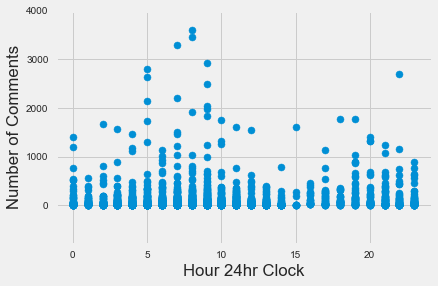

In [252]:
plt.style.use('fivethirtyeight')
plt.scatter(data.hour, data.num_comments)
plt.ylim(ymax=4000)
plt.xlabel('Hour 24hr Clock')
plt.ylabel('Number of Comments')

In [210]:
word_freq = pd.DataFrame([cvect.get_feature_names(), list(titles_vect.toarray().sum(axis=0))]).T

In [212]:
word_freq.rename(columns={0:'words', 1:'frequency'}, inplace=True)
word_freq.head(15)

,words,frequency
0,15s marco,4
1,15s marco rubio,4
2,15s marco rubio easy,4
3,ago today,5
4,aide plead,4
5,aide plead guilty,4
6,aide plead guilty mueller,4
7,ancient link,4
8,ancient link overpowered,4
9,anti gun,4


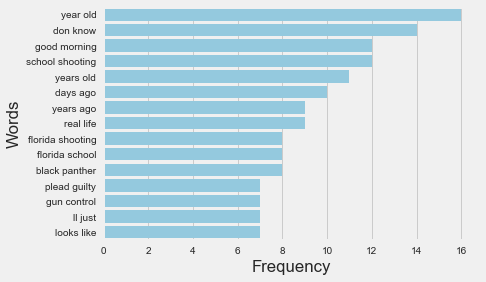

In [217]:
ax= sns.barplot(x='frequency', y='words', data = word_freq.sort_values(by = 'frequency', ascending = False).head(15), color = 'skyblue', )
ax.set(xlabel='Frequency', ylabel='Words');

In [228]:
pd.set_option('display.max_colwidth', -1)
data[['title', 'sentiment']].sort_values(by='sentiment', ascending=False)

,title,sentiment
2920,Today is my final day in a job I've loved and enjoyed at @Goal. Thank you to everyone who has engaged with my content - I truly appreciate it. And a deep gratitude to all the talented people I've worked with over the past two-plus years.,0.9738
4701,"the white suburban boys. Those kids are sitting around seething, feeding on stupid fucking bullshit ass propaganda telling them to hate and blame. The weaker ones snap first. Globalists, SJWs, immigrants, leftists, blacks, whatever. There isn’t any shortage of targets. [+202 GILDED]",0.9736
1343,Fukushima nuclear disaster dumping 300 tons of waste a day into Pacific Ocean for years now. This is an ongoing problem for the world with no end in sight. A major cover-up of this disaster is a crime against us all.,0.9716
1876,"Children in South Sudan have been forced to watch their mothers being raped and killed, UN says...40 officials may be individually responsible for war crimes and crimes against humanity...civilians have been tortured and mutilated, and villages destroyed on industrial scale.",0.9702
76,"Inmates and officers say New Jersey failed to stop sex abuse behind bars. ""I was sexually abused by a corrections officer. I saw countless women raped while serving my time. I spoke up, I complained, I reported it.""",0.9652
696,"Saudi government have released my best friend Noha Al-balawi finally. Sentenced six months for her feminist opinions; She got free yesterday for good behavior. Thank you Reddit for getting my last post to the front page, had to delete it for security reasons. Thank you all",0.9633
2215,This is Bowie. He lived on the streets of Greece for 3 years. He was shot with a shotgun by an unknown man on April 27th 2017. Unfortunately not all of the 20 bullets could be removed but they’re not life threatening. He is so happy and thankful to live a normal life!,0.9539
2940,Hope everyone's happy and well. If you are feeling down things can only get better. This community can also help. Believe in yourself like others believe in you.,0.9460
3692,REMINDER Keith Maresca brutally humiliated and violently attacked a helpless elderly woman,0.9451
4549,"[Klis] Brock Osweiler: “I told John at the end of the season that I would love to be a Bronco, And I’d love to finish my career as a Bronco. I told him regardless of what role I have, being a Bronco is something I take great pride in and is something that means a lot to me.""",0.9423


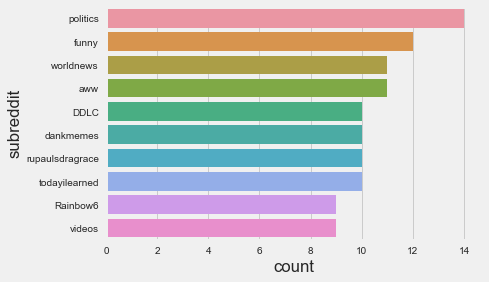

In [237]:
sns.countplot(y=data['subreddit'], order=data.subreddit.value_counts().iloc[:10].index)

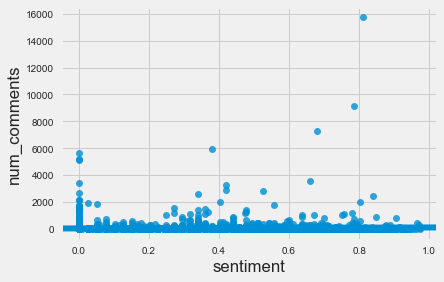

In [272]:
sns.regplot(x='sentiment', y='num_comments', data=data)

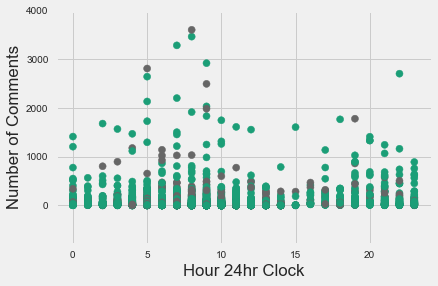

In [291]:
plt.style.use('fivethirtyeight')
plt.scatter(data.hour, data.num_comments, c = round(data.sentiment), cmap='Dark2')
plt.ylim(ymax=4000)
plt.xlabel('Hour 24hr Clock')
plt.ylabel('Number of Comments')


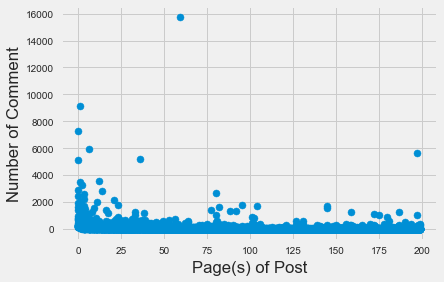

In [266]:
plt.scatter(x=data.index//25, y=data.num_comments)
plt.xlabel('Page(s) of Post')
plt.ylabel('Number of Comment')
#sns.lmplot(x='sentiment', y='num_comments', data=data)
#data.subreddit.value_counts().iloc[:5]

In [276]:
data.sort_values(by='num_comments', ascending = False)

,title,subreddit,time,num_comments,high_low,cat,funny,sentiment,hour
1487,"Other than Hitler’s mustache, what style or fashion was completely ruined by negative association?",AskReddit,2018-02-22 21:41:53,15742.0,1,0,0,0.8104,21
42,"Florida school shooting: Sheriff got 18 calls about Nikolas Cruz's violence, threats, guns",news,2018-02-23 07:16:51,9134.0,1,0,0,0.7845,7
15,What do you think that popular culture will romanticize about the 2010s?,AskReddit,2018-02-23 10:00:46,7274.0,1,0,0,0.6808,10
157,Germany confirms $44.9 billion surplus and GDP growth in 2017,worldnews,2018-02-23 04:22:50,5951.0,1,0,0,0.3818,4
4948,Trump: ‘Maybe They Have to Put a Rating System’ on Movies,movies,2018-02-22 15:58:04,5633.0,1,0,0,0.0000,15
902,What opinion of yours did a complete 180?,AskReddit,2018-02-23 02:49:48,5240.0,1,0,0,0.0000,2
1,Change My Mind,funny,2018-02-23 11:17:59,5131.0,1,0,0,0.0000,11
323,Florida shooting survivor: We should call AR-15s ‘Marco Rubio’ because they’re both easy to buy,politics,2018-02-23 08:23:29,3604.0,1,0,0,0.6597,8
27,Reddit in a nutshell,Wellthatsucks,2018-02-23 08:46:04,3464.0,1,0,0,0.0000,8
72,German Shepherd Beaten And Shot Multiple Times Saving His 16-Years-Old Owners From Burglars,pics,2018-02-23 07:16:34,3285.0,1,0,0,0.4215,7


In [277]:
data[data.subreddit == 'AskReddit']

,title,subreddit,time,num_comments,high_low,cat,funny,sentiment,hour
15,What do you think that popular culture will romanticize about the 2010s?,AskReddit,2018-02-23 10:00:46,7274.0,1,0,0,0.6808,10
280,"Rich people of Reddit, how did you make all your money and become rich?",AskReddit,2018-02-23 09:04:44,1985.0,1,0,0,0.8020,9
542,"If you inherited $100 billion but couldn't tell anyone, how would you live your life?",AskReddit,2018-02-23 05:32:21,2134.0,1,0,0,0.0000,5
902,What opinion of yours did a complete 180?,AskReddit,2018-02-23 02:49:48,5240.0,1,0,0,0.0000,2
1487,"Other than Hitler’s mustache, what style or fashion was completely ruined by negative association?",AskReddit,2018-02-22 21:41:53,15742.0,1,0,0,0.8104,21
2606,"Non native English speakers of Reddit, what are some common sayings in your language that don't make any sense when translated to English?",AskReddit,2018-02-23 02:25:15,1680.0,1,0,0,0.0000,2
3988,What was your dream job when you were 10? When you were 18? And what do you do now?,AskReddit,2018-02-23 09:52:17,1250.0,1,0,0,0.3695,9
4677,What word do you pronounce wrong on purpose?,AskReddit,2018-02-23 10:53:08,1262.0,1,0,0,0.4767,10


#### I wanted to see the performance of a Naive Bayes model

In [292]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
model_scores['NB subreddit only'] = cross_val_score(nb, Xsub, y).mean()
model_scores['NB cat or funny'] = cross_val_score(nb, X, y).mean()
model_scores

{'NB cat or funny': 0.51780004143228975,
 'NB subreddit only': 0.67739357290606705,
 'RF cat or funny': 0.51639948120820012,
 'RF subreddit + title + sentiment': 0.6407926097853659,
 'RF subreddit + title + sentiment + time': 0.6686000134906992,
 'RF subreddit + titles': 0.67719301277799671,
 'RF subreddits only': 0.66899273206583176}

In [293]:
model_scores['NB w/Everything'] = cross_val_score(nb, X_vader_time, y).mean()
model_scores

{'NB cat or funny': 0.51780004143228975,
 'NB subreddit only': 0.67739357290606705,
 'NB w/Everything': 0.68139397330617912,
 'RF cat or funny': 0.51639948120820012,
 'RF subreddit + title + sentiment': 0.6407926097853659,
 'RF subreddit + title + sentiment + time': 0.6686000134906992,
 'RF subreddit + titles': 0.67719301277799671,
 'RF subreddits only': 0.66899273206583176}

In [301]:
pd.DataFrame.from_dict(model_scores, orient = 'index').sort_values(by=0)

,0
RF cat or funny,0.516399
NB cat or funny,0.517800
RF subreddit + title + sentiment,0.640793
RF subreddit + title + sentiment + time,0.668600
RF subreddits only,0.668993
RF subreddit + titles,0.677193
NB subreddit only,0.677394
NB w/Everything,0.681394


### Very interesting to see that subreddit name dominated our accuracy score. Also Naive Bayes performed quite well without any tuning and supports the notion that a Bayesian approach towards NLP works quite well